In [1]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import pandas as pd
import numpy as np

#update_time: the date seperate traing set and testing set
update_time='2020-4-05'


df=pd.read_csv('covid_19_clean_complete.csv')
df['Date']=df.Date.apply(lambda x:x+'20')
df['Date']=pd.to_datetime(df['Date'], format="%m/%d/%Y")
df=df[df['Date']> pd.to_datetime('2020-02-28')] #comma this to see the result by using data from Jan 22nd
update=df[df['Date']>= pd.to_datetime(update_time)]
df=df[df['Date']<=pd.to_datetime(update_time)]


USA=df[df['Country/Region']=='US'].reset_index()
Spain=df[df['Country/Region']=='Spain'].reset_index()
Germany=df[df['Country/Region']=='Germany'].reset_index()
Italy=df[df['Country/Region']=='Italy'].reset_index()
Canada=df[df['Country/Region']=='Canada'].groupby('Date').sum().reset_index()
Canada['Country/Region']='Canada'
Canada_detail=df[df['Country/Region']=='Canada'].groupby(['Province/State','Date']).sum().reset_index()
US_new=update[update['Country/Region']=='US'].set_index('Date')
Spain_new=update[update['Country/Region']=='Spain'].set_index('Date')
Italy_new=update[update['Country/Region']=='Italy'].set_index('Date')
Germany_new=update[update['Country/Region']=='Germany'].set_index('Date')
Canada_new=update[update['Country/Region']=='Canada'].groupby('Date').sum().reset_index().set_index('Date')
Canada_new['Country/Region']='Canada'

In [2]:
#MLP model building and evaluate by MSE for 5 country

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
def MLP_prediction(arima_data,update):
    country=arima_data['Country/Region'][0]
    #country=arima_data['Province/State'][0]
    data=arima_data[['Date','Confirmed']]

    data.columns = ['ds','y']
    data = data.loc[:,["y"]]
    x = np.arange(len(data)).reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=26)
    _=model.fit(x, y.ravel())
    test = np.arange(len(data)+30).reshape(-1, 1)
    pred = model.predict(test)
    prediction = pred.round().astype(int)

    prediction = pd.DataFrame()
    prediction[country]=pred
    prediction['Date']=pd.date_range(start=arima_data['Date'][0],periods=len(data)+30)
    prediction=prediction.set_index('Date')
    USA=arima_data.set_index('Date')
    prediction[country+'_Confirmed']=USA['Confirmed']
   
    error_df=prediction.dropna()
    prediction[country+'_update']=update['Confirmed']
    #prediction.plot(figsize=(20,10))
    
    mse=mean_squared_error(error_df[country],error_df[country+"_Confirmed"])
    return prediction,mse

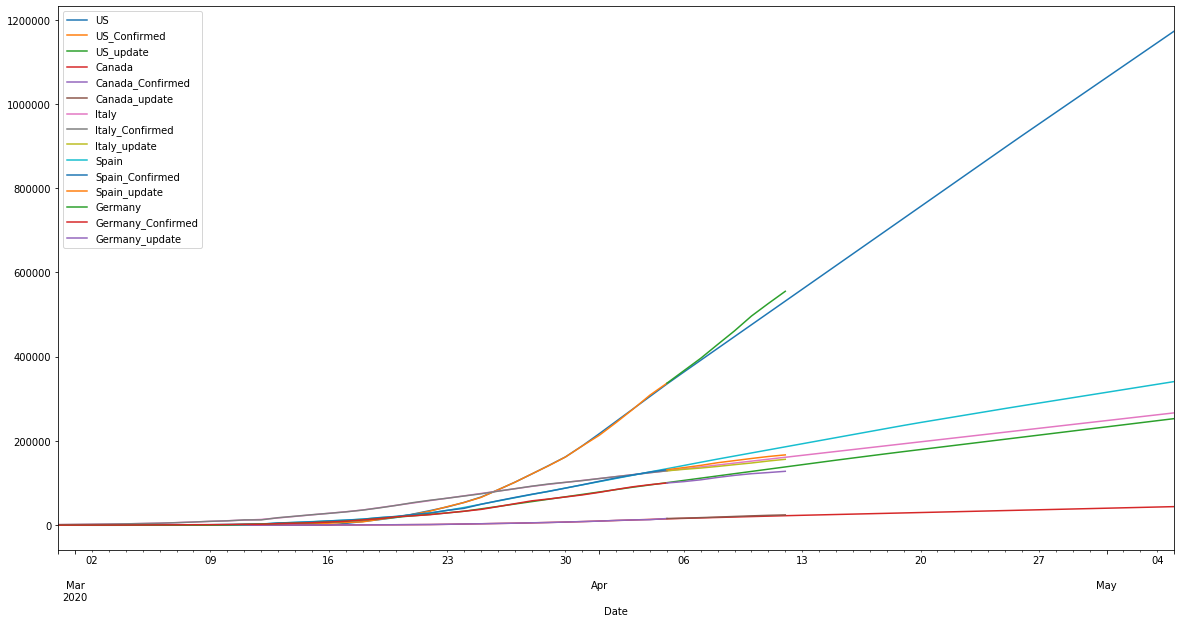

In [4]:
#prediction for USA,Canada,Italy, Spain,Germany
pre_USA,mse_usa=MLP_prediction(USA,US_new)
pre_Canada,mse_ca=MLP_prediction(Canada,Canada_new)
pre_Italy,mse_itl=MLP_prediction(Italy,Italy_new)
pre_Spain,mse_spn=MLP_prediction(Spain,Spain_new)
pre_Germany,mse_gem=MLP_prediction(Germany,Germany_new)

pre_five=pd.concat([pre_USA,pre_Canada,pre_Italy,pre_Spain,pre_Germany],axis=1)
pre_five.plot(figsize=(20,10))



In [5]:
#MSE for US, Canada, Italy, Spain, Germany
list=[mse_usa,mse_ca,mse_itl,mse_spn,mse_gem]
list

[2698011.689743031,
 36312.595329719596,
 148188.24950497385,
 596618.7071626344,
 477422.83283444884]

In [6]:
pre_five[['Canada','Canada_Confirmed','Canada_update']].tail(40)


,Canada,Canada_Confirmed,Canada_update
Date,,,
2020-03-27,4646.594282,4682.0,NaN
2020-03-28,5391.924531,5576.0,NaN
2020-03-29,6350.034407,6280.0,NaN
2020-03-30,7308.144283,7398.0,NaN
2020-03-31,8408.439563,8527.0,NaN
2020-04-01,9713.481606,9560.0,NaN
2020-04-02,11018.523649,11284.0,NaN
2020-04-03,12323.565692,12437.0,NaN
2020-04-04,13628.607736,12978.0,NaN


In [7]:
#MLP mnodel build for provinces in Canada
def MLP_prediction(arima_data):
    #country=arima_data['Country/Region'][0]
    country=arima_data['Province/State'][0]
    data=arima_data[['Date','Confirmed']]

    data.columns = ['ds','y']
    data = data.loc[:,["y"]]
    x = np.arange(len(data)).reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=26)
    _=model.fit(x, y.ravel())
    test = np.arange(len(data)+30).reshape(-1, 1)
    pred = model.predict(test)
    prediction = pred.round().astype(int)

    prediction = pd.DataFrame()
    prediction[country]=pred
    prediction['Date']=pd.date_range(start=arima_data['Date'][0],periods=len(data)+30)
    prediction=prediction.set_index('Date')
    USA=arima_data.set_index('Date')
    prediction[country+'_Confirmed']=USA['Confirmed']
   
    error_df=prediction.dropna()
    #prediction.plot(figsize=(20,10))
    
    mse=mean_squared_error(error_df[country],error_df[country+"_Confirmed"])
    return prediction,mse

In [8]:
#data preprocess for province in Canada
AB=Canada_detail[Canada_detail['Province/State']=='Alberta'].reset_index()
BC=Canada_detail[Canada_detail['Province/State']=='British Columbia'].reset_index()
ON=Canada_detail[Canada_detail['Province/State']=='Ontario'].reset_index()
QB=Canada_detail[Canada_detail['Province/State']=='Saskatchewan'].reset_index()
MN=Canada_detail[Canada_detail['Province/State']=='Manitoba'].reset_index()
NB=Canada_detail[Canada_detail['Province/State']=='New Brunswick'].reset_index()
NS=Canada_detail[Canada_detail['Province/State']=='Nova Scotia'].reset_index()
#AB_new=Canada_new[Canada_new['Province/State']=='Alberta'].reset_index()
AB

,index,Province/State,Date,Lat,Long,Confirmed,Deaths,Recovered
0,0,Alberta,2020-02-29,53.9333,-116.5765,0,0,0
1,1,Alberta,2020-03-01,53.9333,-116.5765,0,0,0
2,2,Alberta,2020-03-02,53.9333,-116.5765,0,0,0
3,3,Alberta,2020-03-03,53.9333,-116.5765,0,0,0
4,4,Alberta,2020-03-04,53.9333,-116.5765,0,0,0
5,5,Alberta,2020-03-05,53.9333,-116.5765,0,0,0
6,6,Alberta,2020-03-06,53.9333,-116.5765,1,0,0
7,7,Alberta,2020-03-07,53.9333,-116.5765,2,0,0
8,8,Alberta,2020-03-08,53.9333,-116.5765,4,0,0
9,9,Alberta,2020-03-09,53.9333,-116.5765,7,0,0


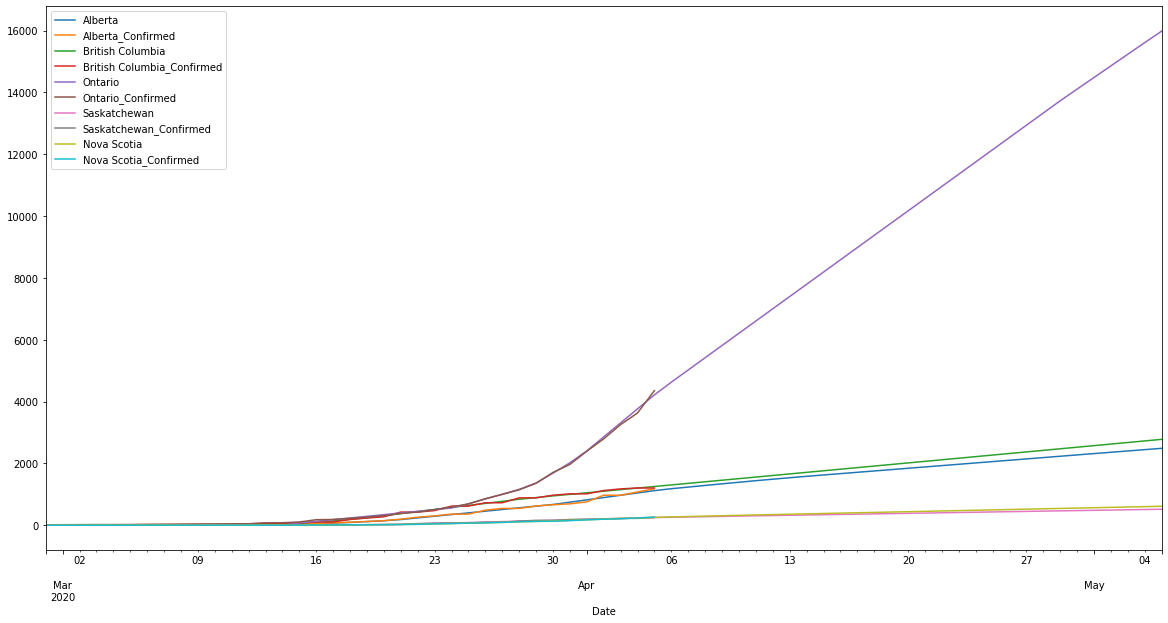

In [9]:
#predicition on each province in Canadad
pre_ab,mse_ab=MLP_prediction(AB)
pre_bc,mse_bc=MLP_prediction(BC)
pre_on,mse_on=MLP_prediction(ON)
pre_qb,mse_qb=MLP_prediction(QB)
pre_ns,mse_ns=MLP_prediction(NS)

pre_five_prov=pd.concat([pre_ab,pre_bc,pre_on,pre_qb,pre_ns],axis=1)
pre_five_prov.plot(figsize=(20,10))

In [10]:
#MSE for Alberta, British Columbia, Ontario, Quebec, Nova Scotia
list=[mse_ab,mse_bc,mse_on,mse_qb,mse_ns]
list

[638.3228539334359,
 886.1947215476057,
 2069.157026541765,
 34.90604446321306,
 11.905919205823615]

In [11]:
#the prediction and actual confirmed cases for the last 40 days
pre_five_prov.tail(40)

,Alberta,Alberta_Confirmed,British Columbia,British Columbia_Confirmed,Ontario,Ontario_Confirmed,Saskatchewan,Saskatchewan_Confirmed,Nova Scotia,Nova Scotia_Confirmed
Date,,,,,,,,,,
2020-03-27,507.081701,542.0,771.729611,725.0,1002.433987,994.0,115.430508,95.0,92.178732,90.0
2020-03-28,561.333562,542.0,837.631860,884.0,1158.595545,1144.0,130.017913,134.0,107.235656,110.0
2020-03-29,615.585424,621.0,892.908117,884.0,1365.693512,1355.0,144.605318,156.0,122.292580,122.0
2020-03-30,669.837285,661.0,946.831703,970.0,1683.138236,1706.0,159.192723,156.0,137.383924,127.0
2020-03-31,744.286895,690.0,997.668570,1013.0,2018.691032,1966.0,173.780128,184.0,156.268561,147.0
2020-04-01,819.011031,754.0,1048.505437,1013.0,2403.674721,2392.0,188.367533,193.0,175.691557,173.0
2020-04-02,893.735167,969.0,1099.342305,1121.0,2856.854962,2793.0,202.954939,206.0,195.114553,193.0
2020-04-03,968.459303,969.0,1150.179172,1174.0,3310.035203,3255.0,217.542344,220.0,214.537549,207.0
2020-04-04,1043.183439,1075.0,1201.016040,1203.0,3763.215443,3630.0,232.129749,220.0,233.960546,236.0
